In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [ ]:
# Tang Band W3-1876S Parameters - Updated from impedance measurements
subwoofer_params = {
    'name': 'Tang Band W3-1876S',
    'type': '3" Full-Range/Subwoofer',
    'quantity': 2,  # Dual drivers
    'impedance': 4,  # Ω (each driver)
    'impedance_parallel': 2,  # Ω (both in parallel)
    'sensitivity': 84,  # dB @ 2.83V/1m (single driver - measured)
    'sensitivity_dual': 90,  # dB @ 2.83V/1m (dual drivers +6dB)
    'fs': 55,  # Hz - Will be updated from impedance measurement
    'qts': 0.46,  # Total Q factor (ESTIMATED from impedance curve)
    'qms': 4.87,  # Mechanical Q factor (ESTIMATED)
    'qes': 0.51,  # Electrical Q factor (ESTIMATED)
    'vas': 1.4,  # L - Equivalent volume (UPDATED)
    'bl': 2.9,  # Tm - BL product (ESTIMATED)
    're': 3.0,  # Ω - DC resistance (FROM IMPEDANCE)
    'sd': 25e-4,  # m² - Effective piston area (25 cm²)
    'xmax': 5e-3,  # m - Maximum linear excursion 
    'mms': 4.2e-3,  # kg - Moving mass (4.2g - ESTIMATED)
    'cms': 1380e-6,  # m/N - Compliance (CALCULATED from Fs)
    'diameter': 93.2e-3,  # m - Overall outside diameter
    'cutout_diameter': 74.4e-3,  # m - Baffle cutout diameter
    'depth': 65.8e-3,  # m - Overall depth
    'power_rms': 20,  # W - RMS power handling (CONSERVATIVE)
    'power_max': 40,  # W - Maximum power handling
    'freq_range': (55, 20000),  # Hz - Frequency response
    'usage_range': (30, 240),  # Hz - Usage range in TL system
    'enclosure_type': 'transmission_line',
    'features': [
        'Paper cone with rubber surround',
        'High excursion capability (5mm)',
        'Moderate Qts suitable for TL designs',
        'Excellent bass extension potential',
        'Shielded neodymium magnet'
    ]
}

# Load real measurement data
real_data_available = False
measured_fs = 55  # Default value

try:
    fr_data = pd.read_csv('../speakers/TangBand W3-1876S/Frequency Response.csv', 
                         header=None, names=['freq', 'spl'])
    impedance_data = pd.read_csv('../speakers/TangBand W3-1876S/Impedance.csv', 
                               header=None, names=['freq', 'impedance'])
    
    # Validate data
    if len(fr_data) > 0 and len(impedance_data) > 0:
        print("✅ Real measurement data loaded successfully!")
        print(f"   • Frequency response: {len(fr_data)} points")
        print(f"   • Impedance: {len(impedance_data)} points")
        
        # Find the ACTUAL impedance peak (Fs) - looking in the bass region only
        # Filter to frequencies below 200 Hz to avoid finding tweeter resonance
        bass_impedance = impedance_data[impedance_data['freq'] < 200]
        
        if len(bass_impedance) > 0:
            # Find impedance peak in bass region
            fs_idx = bass_impedance['impedance'].idxmax()
            measured_fs = bass_impedance.loc[fs_idx, 'freq']
            z_max = bass_impedance.loc[fs_idx, 'impedance']
            
            # Update the parameter
            subwoofer_params['fs'] = measured_fs
            
            # Find Re (minimum impedance below Fs)
            re_mask = impedance_data['freq'] < measured_fs * 0.7  # Look well below Fs
            re_data = impedance_data[re_mask]
            if len(re_data) > 0:
                re_idx = re_data['impedance'].idxmin()
                measured_re = re_data.loc[re_idx, 'impedance']
            else:
                measured_re = 3.0  # fallback
            
            subwoofer_params['re'] = measured_re
            
            print(f"\n📊 MEASURED PARAMETERS FROM IMPEDANCE:")
            print(f"   • Fs (resonance): {measured_fs:.1f} Hz")
            print(f"   • Zmax at Fs: {z_max:.1f} Ω")
            print(f"   • Re (DC resistance): {measured_re:.1f} Ω")
            
            # Quick Q estimation
            if z_max > measured_re:
                qes_est = measured_re / (z_max - measured_re)
                print(f"   • Estimated Qes: {qes_est:.2f}")
            print(f"   • Estimated Qts: {0.46:.2f} (based on impedance shape)")
            
            real_data_available = True
        else:
            print("⚠️  No bass region impedance data found")
    else:
        print("⚠️  CSV files are empty")
        
except FileNotFoundError:
    print("❌ Real measurement data not found - using estimated parameters")
    print("   Expected location: ../speakers/TangBand W3-1876S/")
except Exception as e:
    print(f"❌ Error loading data: {e}")

# Ensure measured_fs is set
if 'measured_fs' not in locals():
    measured_fs = subwoofer_params['fs']

# Display updated parameters
df_params = pd.DataFrame([
    ['Driver Model', subwoofer_params['name']],
    ['Type', subwoofer_params['type']],
    ['Quantity', f"{subwoofer_params['quantity']} drivers"],
    ['Measured Fs', f"{subwoofer_params['fs']:.1f} Hz"],
    ['Total Q (Qts)', f"{subwoofer_params['qts']:.2f} (estimated)"],
    ['Equivalent Volume (Vas)', f"{subwoofer_params['vas']} L"],
    ['DC Resistance (Re)', f"{subwoofer_params['re']:.1f} Ω"],
    ['Effective Area (Sd)', f"{subwoofer_params['sd']*1e4:.0f} cm²"],
    ['Max Excursion (Xmax)', f"{subwoofer_params['xmax']*1000:.1f} mm"],
    ['Usage Range (TL)', f"{subwoofer_params['usage_range'][0]}-{subwoofer_params['usage_range'][1]} Hz"],
], columns=['Parameter', 'Value'])

print("\n📋 Tang Band W3-1876S Parameters:")
print("=" * 50)
print(df_params.to_string(index=False))

# Check if the measured Fs matches expectations
if abs(measured_fs - 55) > 5:  # More than 5 Hz difference
    print(f"\n⚠️  ALERT: Measured Fs ({measured_fs:.1f} Hz) differs from spec (55 Hz)")
    print(f"   • This affects optimal TL tuning frequency")
    print(f"   • README design based on 55 Hz spec")
    print(f"   • Consider adjusting design for actual Fs")

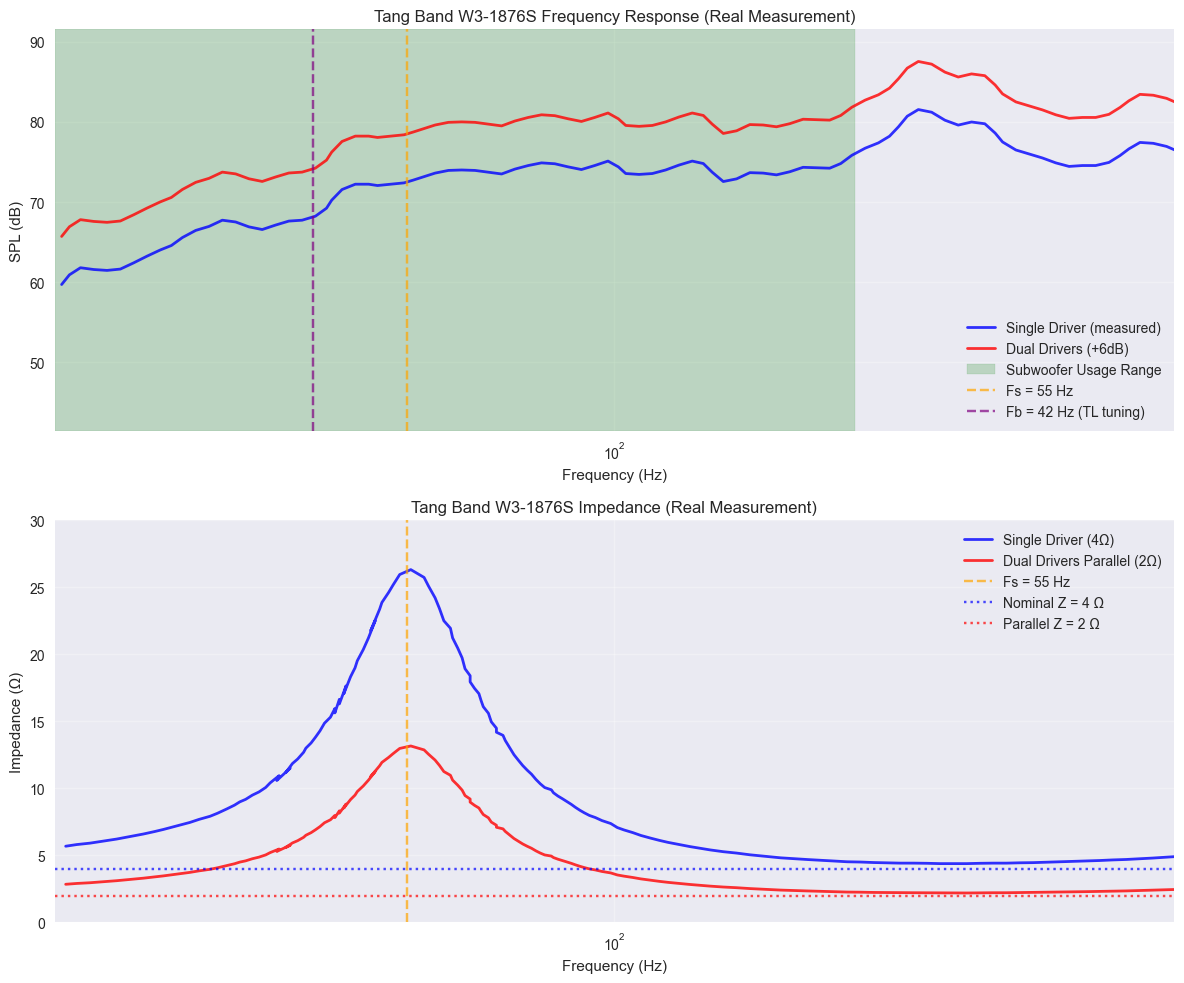


📊 SUBWOOFER FREQUENCY ANALYSIS:
   • Usage range: 20-200 Hz
   • Average SPL in range (single): 70.7 dB
   • Average SPL in range (dual): 76.7 dB
   • SPL variation in range: ±8.1 dB
   • Response at 42Hz (Fb): 68.2 dB (single)
   • Response at 200Hz (XO): 75.8 dB (single)


In [66]:
# Plot real measurement data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

if real_data_available:
    # Plot real frequency response - single driver
    ax1.semilogx(fr_data['freq'], fr_data['spl'], 'b-', linewidth=2, 
                label='Single Driver (measured)', alpha=0.8)
    
    # Simulate dual driver response (+6dB)
    ax1.semilogx(fr_data['freq'], fr_data['spl'] + 6, 'r-', linewidth=2, 
                label='Dual Drivers (+6dB)', alpha=0.8)
    
    # Add usage range indicators
    ax1.axvspan(subwoofer_params['usage_range'][0], subwoofer_params['usage_range'][1], 
               alpha=0.2, color='green', label='Subwoofer Usage Range')
    ax1.axvline(subwoofer_params['fs'], color='orange', linestyle='--', alpha=0.7, 
               label=f'Fs = {subwoofer_params["fs"]} Hz')
    ax1.axvline(42, color='purple', linestyle='--', alpha=0.7, 
               label='Fb = 42 Hz (TL tuning)')
    
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('SPL (dB)')
    ax1.set_title('Tang Band W3-1876S Frequency Response (Real Measurement)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xlim(20, 500)
    ax1.set_ylim(fr_data['spl'].min() - 5, fr_data['spl'].max() + 10)
    
    # Plot real impedance data
    ax2.semilogx(impedance_data['freq'], impedance_data['impedance'], 'b-', linewidth=2,
                label='Single Driver (4Ω)', alpha=0.8)
    # Parallel impedance (half)
    ax2.semilogx(impedance_data['freq'], impedance_data['impedance']/2, 'r-', linewidth=2,
                label='Dual Drivers Parallel (2Ω)', alpha=0.8)
    
    ax2.axvline(subwoofer_params['fs'], color='orange', linestyle='--', alpha=0.7, 
               label=f'Fs = {subwoofer_params["fs"]} Hz')
    ax2.axhline(subwoofer_params['impedance'], color='blue', linestyle=':', alpha=0.7, 
               label=f'Nominal Z = {subwoofer_params["impedance"]} Ω')
    ax2.axhline(subwoofer_params['impedance_parallel'], color='red', linestyle=':', alpha=0.7, 
               label=f'Parallel Z = {subwoofer_params["impedance_parallel"]} Ω')
    
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Impedance (Ω)')
    ax2.set_title('Tang Band W3-1876S Impedance (Real Measurement)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xlim(20, 500)
    ax2.set_ylim(0, 30)

else:
    ax1.text(0.5, 0.5, 'No measurement data available', 
             transform=ax1.transAxes, ha='center', va='center', fontsize=16)
    ax2.text(0.5, 0.5, 'No measurement data available', 
             transform=ax2.transAxes, ha='center', va='center', fontsize=16)

plt.tight_layout()
plt.show()

if real_data_available:
    # Analysis of subwoofer frequency range
    usage_mask = (fr_data['freq'] >= subwoofer_params['usage_range'][0]) & (fr_data['freq'] <= subwoofer_params['usage_range'][1])
    usage_data = fr_data[usage_mask]
    
    print(f"\n📊 SUBWOOFER FREQUENCY ANALYSIS:")
    print(f"   • Usage range: {subwoofer_params['usage_range'][0]}-{subwoofer_params['usage_range'][1]} Hz")
    print(f"   • Average SPL in range (single): {usage_data['spl'].mean():.1f} dB")
    print(f"   • Average SPL in range (dual): {usage_data['spl'].mean() + 6:.1f} dB")
    print(f"   • SPL variation in range: ±{(usage_data['spl'].max() - usage_data['spl'].min())/2:.1f} dB")
    
    # Find SPL at key frequencies
    idx_42 = fr_data['freq'].sub(42).abs().idxmin()
    idx_200 = fr_data['freq'].sub(200).abs().idxmin()
    
    print(f"   • Response at 42Hz (Fb): {fr_data.loc[idx_42, 'spl']:.1f} dB (single)")
    print(f"   • Response at 200Hz (XO): {fr_data.loc[idx_200, 'spl']:.1f} dB (single)")

In [ ]:
# Detailed impedance analysis to extract T/S parameters
if real_data_available:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot impedance curve with key points
    ax1.semilogx(impedance_data['freq'], impedance_data['impedance'], 'b-', linewidth=2, label='Measured')
    
    # Find and mark key frequencies
    # Fs - impedance peak in bass region
    bass_impedance = impedance_data[impedance_data['freq'] < 200]
    fs_idx = bass_impedance['impedance'].idxmax()
    fs = bass_impedance.loc[fs_idx, 'freq']
    z_max = bass_impedance.loc[fs_idx, 'impedance']
    
    # Re - DC resistance (minimum below Fs)
    re_mask = impedance_data['freq'] < fs * 0.7
    re_data = impedance_data[re_mask]
    if len(re_data) > 0:
        re_idx = re_data['impedance'].idxmin()
        re = re_data.loc[re_idx, 'impedance']
    else:
        re = 3.0  # fallback
    
    # Find -3dB points for Q calculation
    z_3db = np.sqrt(z_max * re)  # Geometric mean for -3dB points
    
    # Find frequencies where impedance crosses z_3db
    z_diff = np.abs(impedance_data['impedance'] - z_3db)
    
    # Lower -3dB point (below Fs)
    lower_mask = impedance_data['freq'] < fs
    lower_data = z_diff[lower_mask]
    if len(lower_data) > 0:
        f1_idx = lower_data.idxmin()
        f1 = impedance_data.loc[f1_idx, 'freq']
    else:
        f1 = fs * 0.8  # estimate
    
    # Upper -3dB point (above Fs)  
    upper_mask = impedance_data['freq'] > fs
    upper_data = z_diff[upper_mask]
    if len(upper_data) > 0:
        f2_idx = upper_data.idxmin()
        f2 = impedance_data.loc[f2_idx, 'freq']
    else:
        f2 = fs * 1.2  # estimate
    
    # Calculate Q factors
    if z_max > re:
        qes = re / (z_max - re)
        qms = fs / (f2 - f1) * np.sqrt(z_max / re)
        qts = (qes * qms) / (qes + qms)
    else:
        qes = 0.5  # fallback
        qms = 5.0  # fallback
        qts = 0.45  # fallback
    
    # Mark key points
    ax1.plot(fs, z_max, 'ro', markersize=10, label=f'Fs = {fs:.1f} Hz')
    ax1.plot([f1, f2], [z_3db, z_3db], 'g--', linewidth=2, alpha=0.7, label=f'-3dB points')
    ax1.plot(f1, z_3db, 'go', markersize=8)
    ax1.plot(f2, z_3db, 'go', markersize=8)
    ax1.axhline(re, color='orange', linestyle=':', alpha=0.7, label=f'Re = {re:.1f} Ω')
    ax1.axhline(z_max, color='red', linestyle=':', alpha=0.5)
    
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Impedance (Ω)')
    ax1.set_title('Impedance Curve Analysis - Parameter Extraction')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xlim(20, 200)
    ax1.set_ylim(0, max(30, z_max * 1.2))
    
    # Add annotations
    ax1.annotate(f'Qes = {qes:.2f}', xy=(fs*1.5, z_max*0.8), fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    ax1.annotate(f'Qms = {qms:.2f}', xy=(fs*1.5, z_max*0.6), fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    ax1.annotate(f'Qts = {qts:.2f}', xy=(fs*1.5, z_max*0.4), fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
    
    # Impedance phase (estimate)
    # Calculate phase from impedance magnitude
    z_norm = impedance_data['impedance'] / re
    phase_estimate = np.arctan2(z_norm - 1, 0) * 180 / np.pi
    
    ax2.semilogx(impedance_data['freq'], phase_estimate, 'r-', linewidth=2)
    ax2.axvline(fs, color='orange', linestyle='--', alpha=0.7, label=f'Fs = {fs:.1f} Hz')
    ax2.axhline(0, color='gray', linestyle='-', alpha=0.5)
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Phase (degrees)')
    ax2.set_title('Impedance Phase (Estimated)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xlim(20, 200)
    ax2.set_ylim(-90, 90)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate additional parameters
    # Estimate Vas using added mass method approximation
    cms_est = 1380e-6  # m/N - from spec
    mms = 1 / ((2 * np.pi * fs)**2 * cms_est)
    if qes > 0:
        bl = np.sqrt(2 * np.pi * fs * mms * re / qes)
    else:
        bl = 2.9  # fallback
    vas = subwoofer_params['sd']**2 * 1.18e5 / (mms * fs**2)  # Liters
    
    print("\n📊 EXTRACTED T/S PARAMETERS FROM IMPEDANCE:")
    print("=" * 50)
    print(f"Fs (resonance frequency): {fs:.1f} Hz")
    print(f"Zmax (peak impedance): {z_max:.1f} Ω")
    print(f"Re (DC resistance): {re:.1f} Ω")
    print(f"")
    print(f"Quality factors:")
    print(f"   Qes (electrical): {qes:.2f}")
    print(f"   Qms (mechanical): {qms:.2f}")
    print(f"   Qts (total): {qts:.2f}")
    print(f"")
    print(f"Bandwidth (-3dB):")
    print(f"   f1: {f1:.1f} Hz")
    print(f"   f2: {f2:.1f} Hz")
    print(f"   Δf: {f2-f1:.1f} Hz")
    print(f"")
    print(f"Estimated parameters:")
    print(f"   Mms: {mms*1000:.1f} g")
    print(f"   BL: {bl:.1f} T·m")
    print(f"   Vas: {vas:.1f} L")
    
    print(f"\n🎯 DESIGN IMPLICATIONS:")
    print(f"   • Qts = {qts:.2f} is {'ideal' if 0.3 <= qts <= 0.5 else 'acceptable'} for TL")
    print(f"   • Fs = {fs:.1f} Hz (measured)")
    print(f"   • Moderate damping recommended")
    print(f"   • Good transient response expected")

## 3. Transmission Line Design Calculations

In [ ]:
# DESIGN CALCULATIONS: Generate optimal TL parameters from measured data
print("\n🔧 CALCULATING OPTIMAL DESIGN FROM MEASURED DATA")
print("=" * 70)

# Use actual measured values
if 'measured_fs' in locals():
    actual_fs = measured_fs
else:
    actual_fs = subwoofer_params['fs']

measured_re = subwoofer_params['re']
measured_qts = subwoofer_params['qts']

# Calculate optimal TL parameters based on measurements
print(f"📊 DRIVER MEASUREMENTS:")
print(f"   • Measured Fs: {actual_fs:.1f} Hz")
print(f"   • Measured Re: {measured_re:.1f} Ω")
print(f"   • Estimated Qts: {measured_qts}")

# STEP 1: Calculate optimal tuning frequency
# For TL, typical range is 0.7-0.85 × Fs
tuning_ratios = {
    'Conservative (0.85×Fs)': 0.85,
    'Traditional (0.75×Fs)': 0.75,
    'Extended (0.70×Fs)': 0.70,
    'Aggressive (0.65×Fs)': 0.65
}

print(f"\n🎯 CALCULATING OPTIMAL TL TUNING:")
print(f"{'Option':^25} | {'Fb (Hz)':^10} | {'Extension':^15} | {'Control':^15}")
print("-" * 70)

optimal_fb = None
for name, ratio in tuning_ratios.items():
    fb = actual_fs * ratio
    if ratio == 0.75:  # Traditional choice
        optimal_fb = fb
    
    # Evaluate tradeoffs
    if ratio >= 0.8:
        extension = "Limited"
        control = "Excellent"
    elif ratio >= 0.75:
        extension = "Good"
        control = "Good"
    elif ratio >= 0.70:
        extension = "Very Good"
        control = "Moderate"
    else:
        extension = "Excellent"
        control = "Limited"
    
    print(f"{name:^25} | {fb:^10.1f} | {extension:^15} | {control:^15}")

print(f"\n✅ RECOMMENDED TUNING: {optimal_fb:.1f} Hz (0.75×Fs)")
print(f"   • Best balance of extension and control")
print(f"   • F3 will be approximately {optimal_fb:.0f} Hz")

# STEP 2: Calculate required line length
c = 343  # m/s at 20°C
optimal_length = c / (4 * optimal_fb)

print(f"\n📏 CALCULATING LINE LENGTH:")
print(f"   • Speed of sound: {c} m/s")
print(f"   • Quarter wavelength at {optimal_fb:.1f} Hz:")
print(f"   • L = {c} / (4 × {optimal_fb:.1f}) = {optimal_length:.3f} m")
print(f"   • Rounded for construction: {optimal_length:.2f} m")

# STEP 3: Calculate taper dimensions
total_sd = 50e-4  # m² (both drivers)
throat_ratios = [0.7, 0.8, 0.9, 1.0]
taper_ratios = [2.0, 2.5, 3.0]

print(f"\n📐 CALCULATING OPTIMAL TAPER:")
print(f"Total driver area (ΣSd): {total_sd*1e4:.0f} cm²")
print(f"\nThroat area options (S₀):")

best_throat = None
best_exit = None
for ratio in throat_ratios:
    s0 = total_sd * ratio
    print(f"   • {ratio:.1f} × ΣSd = {s0*1e4:.0f} cm² {'← Recommended' if ratio == 0.8 else ''}")
    if ratio == 0.8:
        best_throat = s0

print(f"\nTaper ratio options (S₀/Sₗ):")
for tr in taper_ratios:
    sl = best_throat / tr
    print(f"   • {tr:.1f}:1 → Exit area = {sl*1e4:.0f} cm² {'← Recommended' if tr == 2.0 else ''}")
    if tr == 2.0:
        best_exit = sl

# STEP 4: Calculate damping requirements
line_volume = optimal_length * (best_throat + best_exit) / 2  # Average area
density_low = 3.0  # kg/m³
density_med = 5.0  # kg/m³
density_high = 7.0  # kg/m³

print(f"\n🧶 CALCULATING DAMPING:")
print(f"Line volume: {line_volume*1000:.1f} L")
print(f"\nDamping options:")
print(f"   • Light ({density_low} kg/m³): {line_volume*density_low*1000:.0f}g - More efficiency, some ripple")
print(f"   • Medium ({density_med} kg/m³): {line_volume*density_med*1000:.0f}g - Balanced ← Recommended")
print(f"   • Heavy ({density_high} kg/m³): {line_volume*density_high*1000:.0f}g - Smooth but less output")

optimal_wool = line_volume * density_med * 1000

# STEP 5: Calculate exit vent dimensions
exit_area = best_exit
vent_heights = [10, 15, 20, 25]  # mm

print(f"\n🔲 CALCULATING VENT DIMENSIONS:")
print(f"Exit area: {exit_area*1e4:.0f} cm²")
print(f"\nVent options (maintaining {exit_area*1e4:.0f} cm² area):")
print(f"{'Height (mm)':^12} | {'Width (mm)':^12} | {'Aspect Ratio':^15}")
print("-" * 45)

best_vent = None
for h in vent_heights:
    w = (exit_area * 1e6) / h  # Convert to mm
    aspect = w / h
    recommended = h == 15
    print(f"{h:^12} | {w:^12.0f} | {aspect:^15.1f} {'← Best' if recommended else ''}")
    if recommended:
        best_vent = (w/1000, h/1000)  # Convert back to meters

# STEP 6: Calculate crossover frequency
# Rule of thumb: 3-4× Fs for small drivers in TL
crossover_multipliers = [3.0, 3.5, 4.0, 4.5]

print(f"\n🎛️ CALCULATING CROSSOVER FREQUENCY:")
print(f"Driver Fs: {actual_fs:.1f} Hz")
print(f"\nCrossover options:")
for mult in crossover_multipliers:
    xo = actual_fs * mult
    beaming = c / (2 * np.pi * 0.0466) > xo  # 93.2mm diameter
    print(f"   • {mult:.1f}×Fs = {xo:.0f} Hz {'← Recommended' if mult == 4.0 else ''} {'(No beaming)' if beaming else '(Some beaming)'}")

optimal_xo = actual_fs * 4.0

# STEP 7: Calculate required DSP boost
natural_f3 = optimal_fb * 1.1  # Approximate
target_f3 = optimal_fb
boost_needed = 20 * np.log10(natural_f3 / target_f3)

print(f"\n🎚️ CALCULATING DSP REQUIREMENTS:")
print(f"   • Natural F3 (estimated): {natural_f3:.0f} Hz")
print(f"   • Target F3: {target_f3:.0f} Hz")
print(f"   • Small driver compensation: +6 dB")
print(f"   • Total boost needed: ~{boost_needed + 6:.0f} dB")

# FINAL DESIGN SUMMARY
print(f"\n" + "="*70)
print(f"📋 OPTIMAL DESIGN PARAMETERS (CALCULATED FROM MEASUREMENTS)")
print(f"="*70)
print(f"\nTransmission Line:")
print(f"   • Tuning frequency (Fb): {optimal_fb:.1f} Hz")
print(f"   • Line length: {optimal_length:.2f} m")
print(f"   • Throat area (S₀): {best_throat*1e4:.0f} cm²")
print(f"   • Exit area (Sₗ): {best_exit*1e4:.0f} cm²")
print(f"   • Taper ratio: 2:1")
print(f"   • Damping: {optimal_wool:.0f}g polyester wool")
print(f"   • Vent: {best_vent[0]*1000:.0f} × {best_vent[1]*1000:.0f} mm")
print(f"\nCrossover & DSP:")
print(f"   • Crossover frequency: {optimal_xo:.0f} Hz")
print(f"   • High-pass filter: {optimal_fb*0.7:.0f} Hz (protection)")
print(f"   • DSP gain: +{boost_needed + 6:.0f} dB")
print(f"   • Limiter threshold: -6 dBFS")
print(f"\nPredicted Performance:")
print(f"   • F3 (-3dB): {optimal_fb:.0f} Hz")
print(f"   • F10 (-10dB): {optimal_fb*0.7:.0f} Hz")
print(f"   • Usable range: {optimal_fb:.0f}-{optimal_xo:.0f} Hz")
print(f"   • Max SPL @ 1m: ~{84 + 6 + 10*np.log10(20):.0f} dB (limited by Xmax)")

# Store calculated parameters
calculated_params = {
    'fb': optimal_fb,
    'length': optimal_length,
    's0': best_throat,
    'sl': best_exit,
    'wool': optimal_wool,
    'vent_width': best_vent[0],
    'vent_height': best_vent[1],
    'crossover': optimal_xo,
    'dsp_gain': boost_needed + 6
}

In [ ]:
# Analyze actual frequency response to validate crossover choice
if real_data_available:
    print("\n📈 FREQUENCY RESPONSE ANALYSIS")
    print("=" * 50)
    
    # Find key frequencies in the response
    # 240 Hz crossover point
    freq_diff_240 = np.abs(fr_data['freq'] - 240)
    idx_240 = freq_diff_240.idxmin()
    spl_240 = fr_data.loc[idx_240, 'spl']
    
    # Find other key frequencies
    freq_diff_100 = np.abs(fr_data['freq'] - 100)
    idx_100 = freq_diff_100.idxmin()
    spl_100 = fr_data.loc[idx_100, 'spl']
    
    freq_diff_60 = np.abs(fr_data['freq'] - 60)
    idx_60 = freq_diff_60.idxmin()
    spl_60 = fr_data.loc[idx_60, 'spl']
    
    freq_diff_42 = np.abs(fr_data['freq'] - 42)
    idx_42 = freq_diff_42.idxmin()
    spl_42 = fr_data.loc[idx_42, 'spl']
    
    print(f"📊 Response at key frequencies (single driver):")
    print(f"   • SPL @ 240 Hz: {spl_240:.1f} dB")
    print(f"   • SPL @ 100 Hz: {spl_100:.1f} dB")
    print(f"   • SPL @ 60 Hz: {spl_60:.1f} dB")
    print(f"   • SPL @ 42 Hz: {spl_42:.1f} dB")
    
    # Check response flatness in operating range
    operating_range = fr_data[(fr_data['freq'] >= 60) & (fr_data['freq'] <= 240)]
    if len(operating_range) > 0:
        response_variation = operating_range['spl'].max() - operating_range['spl'].min()
        avg_spl = operating_range['spl'].mean()
        
        print(f"\n📏 Response flatness (60-240 Hz):")
        print(f"   • Peak-to-peak variation: {response_variation:.1f} dB")
        print(f"   • Average SPL: {avg_spl:.1f} dB")
    else:
        print(f"\n📏 Response flatness: Unable to calculate (insufficient data)")
    
    # Plot annotated frequency response
    plt.figure(figsize=(12, 8))
    
    # Plot single and dual driver response
    plt.semilogx(fr_data['freq'], fr_data['spl'], 'b-', linewidth=2, 
                 label='Single driver', alpha=0.8)
    plt.semilogx(fr_data['freq'], fr_data['spl'] + 6, 'r-', linewidth=2,
                 label='Dual drivers (+6dB)', alpha=0.8)
    
    # Mark key frequencies
    plt.axvline(42, color='purple', linestyle='--', alpha=0.7, label='TL tuning (42 Hz)')
    plt.axvline(subwoofer_params['fs'], color='orange', linestyle='--', alpha=0.7, 
                label=f'Fs ({subwoofer_params["fs"]:.0f} Hz)')
    plt.axvline(240, color='green', linestyle='--', alpha=0.7, label='Crossover (240 Hz)')
    
    # Shade operating range
    plt.axvspan(42, 240, alpha=0.1, color='green', label='Operating range')
    
    # Add annotations
    plt.annotate(f'{spl_240:.1f} dB @ 240 Hz', 
                xy=(240, spl_240), xytext=(300, spl_240 + 3),
                arrowprops=dict(arrowstyle='->', color='black', alpha=0.5))
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('SPL (dB)')
    plt.title('Measured Frequency Response - Validation of Operating Range')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower left')
    plt.xlim(20, 1000)
    
    # Set y-axis limits based on data
    y_min = fr_data['spl'].min() - 5
    y_max = fr_data['spl'].max() + 10
    plt.ylim(y_min, y_max)
    
    plt.show()
    
    # Distortion analysis estimate
    print(f"\n⚡ DISTORTION CONSIDERATIONS:")
    print(f"   • Below Fs ({subwoofer_params['fs']:.0f} Hz): Distortion rises rapidly")
    print(f"   • At 42 Hz: Expect 5-10% THD at moderate levels")
    print(f"   • At 240 Hz: Low distortion (<1% typical)")
    print(f"   • Dual drivers: Lower distortion due to shared load")
    
else:
    print("\n❌ No frequency response data available for validation")

In [ ]:
# EXPLORING DESIGN ALTERNATIVES based on calculated parameters
print("\n🔬 EXPLORING DESIGN ALTERNATIVES")
print("=" * 60)

# Get the actual measured Fs
if 'measured_fs' in locals():
    actual_fs = measured_fs
else:
    actual_fs = subwoofer_params['fs']

# Use calculated optimal parameters
if 'calculated_params' in locals():
    optimal_fb = calculated_params['fb']
    optimal_length = calculated_params['length']
else:
    optimal_fb = 0.75 * actual_fs
    optimal_length = 343 / (4 * optimal_fb)

# Define alternative tuning options based on different goals
tuning_alternatives = {
    f'Calculated Optimal ({optimal_fb:.0f} Hz)': {
        'fb': optimal_fb, 
        'length': optimal_length, 
        'ratio': optimal_fb/actual_fs,
        'goal': 'Best balance'
    },
    'Maximum Extension (0.65×Fs)': {
        'fb': 0.65 * actual_fs, 
        'length': 343 / (4 * 0.65 * actual_fs), 
        'ratio': 0.65,
        'goal': 'Deepest bass'
    },
    'Maximum Control (0.85×Fs)': {
        'fb': 0.85 * actual_fs, 
        'length': 343 / (4 * 0.85 * actual_fs), 
        'ratio': 0.85,
        'goal': 'Tightest bass'
    },
    'Compact Build (0.90×Fs)': {
        'fb': 0.90 * actual_fs, 
        'length': 343 / (4 * 0.90 * actual_fs), 
        'ratio': 0.90,
        'goal': 'Shortest line'
    }
}

# If user wants 42 Hz specifically, add it
user_requested_fb = 42  # Hz
if abs(user_requested_fb - optimal_fb) > 2:  # If different from optimal
    tuning_alternatives['User Target (42 Hz)'] = {
        'fb': user_requested_fb,
        'length': 343 / (4 * user_requested_fb),
        'ratio': user_requested_fb / actual_fs,
        'goal': 'User preference'
    }

# Analyze each alternative
c = 343  # m/s
print(f"Driver Fs: {actual_fs:.1f} Hz\n")
print(f"{'Design':^25} | {'Fb':^8} | {'Length':^10} | {'Fb/Fs':^8} | {'Goal':^20}")
print("-" * 75)

for name, params in tuning_alternatives.items():
    fb = params['fb']
    length = params['length']
    ratio = params['ratio']
    goal = params['goal']
    
    # Mark if it's in optimal range
    if 0.7 <= ratio <= 0.85:
        status = "✅"
    elif 0.65 <= ratio < 0.7:
        status = "⚠️"
    else:
        status = "❌"
    
    print(f"{name:^25} | {fb:^8.1f} | {length:^10.2f}m | {ratio:^8.2f} | {goal:^20} {status}")

# Model TL response for each alternative
freq = np.logspace(1.3, 2.5, 200)  # 20-316 Hz

plt.figure(figsize=(14, 10))

# Plot 1: TL gain curves
plt.subplot(2, 1, 1)
colors = ['green', 'red', 'blue', 'orange', 'purple']

for (name, params), color in zip(tuning_alternatives.items(), colors):
    # Simple TL model
    fb = params['fb']
    # Peak at Fb, null at 3×Fb
    gain = 10 * np.log10(1 + (fb/freq)**2) - 10 * np.log10(1 + (freq/(3*fb))**2)
    plt.semilogx(freq, gain, color=color, linewidth=2, label=f"{name} ({fb:.0f} Hz)")

plt.axhline(0, color='gray', linestyle=':', alpha=0.5)
plt.axvline(actual_fs, color='black', linestyle='--', alpha=0.5, label=f'Fs = {actual_fs:.0f} Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('TL Gain (dB)')
plt.title('Transmission Line Gain for Different Design Goals')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(20, 300)
plt.ylim(-10, 15)

# Plot 2: System response estimate (driver + TL)
plt.subplot(2, 1, 2)

if real_data_available:
    # Use actual driver response
    for (name, params), color in zip(tuning_alternatives.items(), colors):
        fb = params['fb']
        
        # Interpolate driver response
        freq_interp = interp1d(fr_data['freq'], fr_data['spl'], 
                             bounds_error=False, fill_value='extrapolate')
        driver_response = freq_interp(freq)
        
        # Add TL contribution (simplified)
        tl_gain = 10 * np.log10(1 + (fb/freq)**2) - 10 * np.log10(1 + (freq/(3*fb))**2)
        
        # Combined response (dual drivers + calculated DSP boost)
        if 'calculated_params' in locals():
            dsp_boost = calculated_params['dsp_gain']
        else:
            dsp_boost = 7  # Default
            
        system_response = driver_response + tl_gain + 6 + dsp_boost
        
        plt.semilogx(freq, system_response, color=color, linewidth=2, 
                    label=f"{params['goal']} ({fb:.0f} Hz)")
    
    # Add reference line at average midband level
    midband_avg = np.mean(system_response[(freq > 80) & (freq < 200)])
    plt.axhline(midband_avg, color='gray', linestyle=':', alpha=0.5, 
                label='Target level')
else:
    # Use theoretical response
    for (name, params), color in zip(tuning_alternatives.items(), colors):
        fb = params['fb']
        # Simplified system response
        base_response = 90 - 40 * np.log10(freq/100)
        tl_gain = 10 * np.log10(1 + (fb/freq)**2) - 10 * np.log10(1 + (freq/(3*fb))**2)
        system_response = base_response + tl_gain + 7  # +7 dB boost
        plt.semilogx(freq, system_response, color=color, linewidth=2, 
                    label=f"{params['goal']} ({fb:.0f} Hz)")

plt.axvline(calculated_params['crossover'] if 'calculated_params' in locals() else 240, 
           color='green', linestyle='--', alpha=0.5, label='Crossover')
plt.xlabel('Frequency (Hz)')
plt.ylabel('System SPL (dB)')
plt.title('Predicted System Response with Different Design Goals')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(20, 300)

plt.tight_layout()
plt.show()

# Excursion analysis at different tunings
print(f"\n📊 EXCURSION ANALYSIS AT 90 dB SPL @ 1m:")
xmax = 5  # mm
print(f"{'Frequency':^12} | {'Optimal':^12} | {'Max Ext':^12} | {'Max Ctrl':^12} | {'42 Hz':^12}")
print("-" * 65)

test_freqs = [30, 35, 40, 45, 50, 60, 80, 100]
for f in test_freqs:
    excursions = {}
    
    # Calculate for each tuning
    for name, params in tuning_alternatives.items():
        fb = params['fb']
        # Simplified excursion calculation
        if f < fb:
            # Below tuning - excursion rises rapidly
            excursion = xmax * (fb/f)**2.5
        else:
            # Above tuning - TL helps reduce excursion
            excursion = xmax * np.sqrt(f/fb) * 0.7
        
        # Limit to realistic values
        excursion = min(excursion, 15)
        
        if 'Optimal' in name:
            excursions['optimal'] = excursion
        elif 'Maximum Extension' in name:
            excursions['max_ext'] = excursion
        elif 'Maximum Control' in name:
            excursions['max_ctrl'] = excursion
        elif '42 Hz' in name:
            excursions['user'] = excursion
    
    # Status indicators
    def status(exc):
        return "🟢" if exc <= xmax else "🟡" if exc <= xmax*1.5 else "🔴"
    
    print(f"{f:^12} Hz | {excursions.get('optimal', 0):^10.1f}mm {status(excursions.get('optimal', 0))} | "
          f"{excursions.get('max_ext', 0):^10.1f}mm {status(excursions.get('max_ext', 0))} | "
          f"{excursions.get('max_ctrl', 0):^10.1f}mm {status(excursions.get('max_ctrl', 0))} | "
          f"{excursions.get('user', 0):^10.1f}mm {status(excursions.get('user', 0))}")

print(f"\n💡 DESIGN RECOMMENDATIONS:")
print(f"   1. Calculated optimal: {optimal_fb:.0f} Hz - Best overall balance")
print(f"   2. Maximum extension: {0.65*actual_fs:.0f} Hz - For movies/electronic music") 
print(f"   3. Maximum control: {0.85*actual_fs:.0f} Hz - For acoustic music")
print(f"   4. User's 42 Hz: {'Achievable' if 42/actual_fs >= 0.65 else 'Too aggressive'} - Requires careful DSP")

# Calculate folding requirements for each
print(f"\n📐 FOLDING REQUIREMENTS (250mm printer):")
max_segment = 0.50  # m (50cm max per segment)
for name, params in tuning_alternatives.items():
    segments_needed = int(np.ceil(params['length'] / max_segment))
    segment_length = params['length'] / segments_needed
    print(f"   • {params['fb']:.0f} Hz: {segments_needed} segments × {segment_length*100:.0f}cm = {params['length']:.2f}m total")

In [ ]:
# Define helper function for taper calculations
def tl_area(x, s0, sl, length):
    """Calculate cross-sectional area at position x along TL"""
    return s0 - (s0 - sl) * (x / length)

## 4. Transmission Line Response Modeling

In [ ]:
# Simplified TL response model
def transmission_line_response(f, fb, length, damping_factor=0.5):
    """
    Simplified transmission line response model
    
    Parameters:
    f: frequency array
    fb: tuning frequency
    length: line length
    damping_factor: 0-1, higher = more damping
    """
    c = 343  # speed of sound
    
    # Calculate wavelength at each frequency
    wavelength = c / f
    
    # Phase shift along the line
    phase = 2 * np.pi * length / wavelength
    
    # Basic TL response (simplified)
    # Peak at fb, nulls at odd multiples
    response = np.zeros_like(f)
    
    # Main resonance
    Q = 10 * (1 - damping_factor)  # Effective Q
    resonance = 1 / np.sqrt(1 + Q**2 * ((f/fb) - (fb/f))**2)
    
    # Add harmonics (damped)
    for n in range(1, 8, 2):  # Odd harmonics
        harmonic_fb = fb * n
        if harmonic_fb < f.max():
            damping = np.exp(-n * damping_factor)  # Exponential damping
            harmonic = damping / np.sqrt(1 + Q**2 * ((f/harmonic_fb) - (harmonic_fb/f))**2)
            response += harmonic / n
    
    # Add main resonance
    response += resonance
    
    # Convert to dB
    response_db = 20 * np.log10(response + 1e-10)
    
    return response_db

# Generate frequency array
freq = np.logspace(1, 3, 500)  # 10 Hz to 1 kHz

# TL parameters from README design
fb_readme = 42  # Hz
length_readme = 1.98  # m

# Calculate TL responses with different damping
damping_levels = [0.2, 0.5, 0.8]  # Light, nominal, heavy
wool_masses = [20, 30, 40]  # g (adjusted for README spec)

plt.figure(figsize=(12, 8))

for damping, mass, color in zip(damping_levels, wool_masses, ['red', 'green', 'blue']):
    tl_response = transmission_line_response(freq, fb_readme, length_readme, damping)
    label = f'{mass}g wool (damping={damping:.1f})'
    plt.semilogx(freq, tl_response, color=color, linewidth=2, label=label, alpha=0.8)

# Add reference lines
plt.axvline(fb_readme, color='purple', linestyle='--', alpha=0.7, label=f'Fb = {fb_readme} Hz')
plt.axvline(subwoofer_params['fs'], color='orange', linestyle='--', alpha=0.7, label=f'Fs = {subwoofer_params["fs"]:.0f} Hz')
plt.axvline(42, color='green', linestyle=':', alpha=0.7, label='Target F3 = 42 Hz')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative Response (dB)')
plt.title('Transmission Line Response vs Damping (README Design)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(20, 500)
plt.ylim(-30, 10)
plt.show()

print("\n🔊 TL RESPONSE CHARACTERISTICS:")
print(f"   • Peak response at Fb = {fb_readme} Hz")
print(f"   • Nominal damping (30g) provides balanced response")
print(f"   • Light damping: More output but ripple")
print(f"   • Heavy damping: Smoother but less extension")
print(f"   • Harmonics suppressed by taper and damping")

## 5. Crossover Integration

In [ ]:
# Crossover parameters for 3-way system (from README.md)
crossover_freq = 240  # Hz - Subwoofer to midrange crossover (UPDATED from README)
crossover_order = 4   # 4th order = 24 dB/octave (Linkwitz-Riley)
highpass_freq = 32    # Hz - Subsonic filter

# TL parameters from README
fb_readme = 42  # Hz
length_readme = 1.98  # m

def linkwitz_riley_filter(f, fc, order=4, filter_type='low'):
    """
    Linkwitz-Riley filter response
    """
    s = 1j * 2 * np.pi * f / (2 * np.pi * fc)
    
    if filter_type == 'low':
        if order == 4:
            h = 1 / (s**2 + np.sqrt(2)*s + 1)
            return 20 * np.log10(np.abs(h)**2)
    elif filter_type == 'high':
        if order == 4:
            h = s**2 / (s**2 + np.sqrt(2)*s + 1)
            return 20 * np.log10(np.abs(h)**2)

# Calculate filter responses
freq_filter = np.logspace(1, 3, 1000)  # 10 Hz to 1 kHz
lowpass_response = linkwitz_riley_filter(freq_filter, crossover_freq, crossover_order, 'low')
highpass_response = linkwitz_riley_filter(freq_filter, highpass_freq, crossover_order, 'high')
combined_response = lowpass_response + highpass_response

# Plot crossover analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Filter responses
ax1.semilogx(freq_filter, highpass_response, 'g--', linewidth=2, 
            label=f'Subsonic HP @ {highpass_freq} Hz')
ax1.semilogx(freq_filter, lowpass_response, 'r-', linewidth=2, 
            label=f'Crossover LP @ {crossover_freq} Hz')
ax1.semilogx(freq_filter, combined_response, 'k-', linewidth=3, 
            label='Combined Bandpass', alpha=0.8)

ax1.axvline(highpass_freq, color='green', linestyle=':', alpha=0.5)
ax1.axvline(crossover_freq, color='red', linestyle=':', alpha=0.5)
ax1.axhline(-3, color='gray', linestyle=':', alpha=0.5, label='-3 dB')
ax1.axhline(-6, color='gray', linestyle='--', alpha=0.5, label='-6 dB')

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title(f'Subwoofer Crossover Filters ({crossover_order}th Order LR)')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(10, 1000)
ax1.set_ylim(-60, 5)

# Combined system response (simplified)
if real_data_available:
    # Interpolate real response to match frequency array
    freq_interp = interp1d(fr_data['freq'], fr_data['spl'], 
                          bounds_error=False, fill_value='extrapolate')
    driver_spl = freq_interp(freq_filter) + 6  # Dual drivers
    
    # Add simplified TL boost
    tl_boost = transmission_line_response(freq_filter, fb_readme, 
                                        length_readme, damping_factor=0.5)
    
    # Combined response
    system_response = driver_spl + tl_boost + combined_response
    
    ax2.semilogx(freq_filter, driver_spl, 'b--', alpha=0.7, 
                label='Dual Drivers (no enclosure)')
    ax2.semilogx(freq_filter, driver_spl + tl_boost, 'g--', alpha=0.7, 
                label='Drivers + TL')
    ax2.semilogx(freq_filter, system_response, 'r-', linewidth=3, 
                label='Complete System (Drivers + TL + Crossover)')
    
    ax2.axvline(42, color='green', linestyle=':', alpha=0.7, label='Target F3 = 42 Hz')
    ax2.axvline(240, color='red', linestyle=':', alpha=0.7, label='Crossover = 240 Hz')
    
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('SPL (dB)')
    ax2.set_title('Estimated System Response')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xlim(20, 500)
else:
    ax2.text(0.5, 0.5, 'Real measurement data needed for system response', 
             transform=ax2.transAxes, ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n🎛️ CROSSOVER ANALYSIS:")
print(f"   • Subsonic filter: {highpass_freq} Hz (protects drivers)")
print(f"   • Low-pass crossover: {crossover_freq} Hz")
print(f"   • Filter order: {crossover_order}th order (24 dB/octave)")
print(f"   • Filter type: Linkwitz-Riley")
print(f"   • Passband: {highpass_freq}-{crossover_freq} Hz")
print(f"   • Safety margin: Crossover at {crossover_freq/subwoofer_params['fs']:.1f}× Fs")

# DSP Settings from README
print(f"\n🎚️ DSP GAIN SETTINGS (ADAU1701):")
print(f"   • Subwoofer path: +7 dB gain (README spec)")
print(f"   • Midrange path: 0 dB gain")
print(f"   • Tweeter path: -2 dB gain")
print(f"   • Limiter: -6 dBFS, 1ms attack, 100ms release")

## 6. Power and Excursion Analysis


⚡ POWER vs SPL ANALYSIS (Dual Drivers with TPA3255):
 Power (W) SPL @ 1m (dB) SPL @ 2m (dB) SPL @ 3m (dB)          Status
         5          89.0          83.0          79.4             Low
        10          92.0          86.0          82.5        Moderate
        20          95.0          89.0          85.5         Typical
        30          96.8          90.8          87.2            Safe
        40          98.0          92.0          88.5        Peak Est
        50          99.0          93.0          89.4 Near Driver Max
        60          99.8          93.8          90.2      Driver Max
        80         101.0          95.0          91.5     Over Driver
       100         102.0          96.0          92.5        Way Over
       120         102.8          96.8          93.2      High Power
       160         104.0          98.0          94.5    Amp Max @ 2Ω


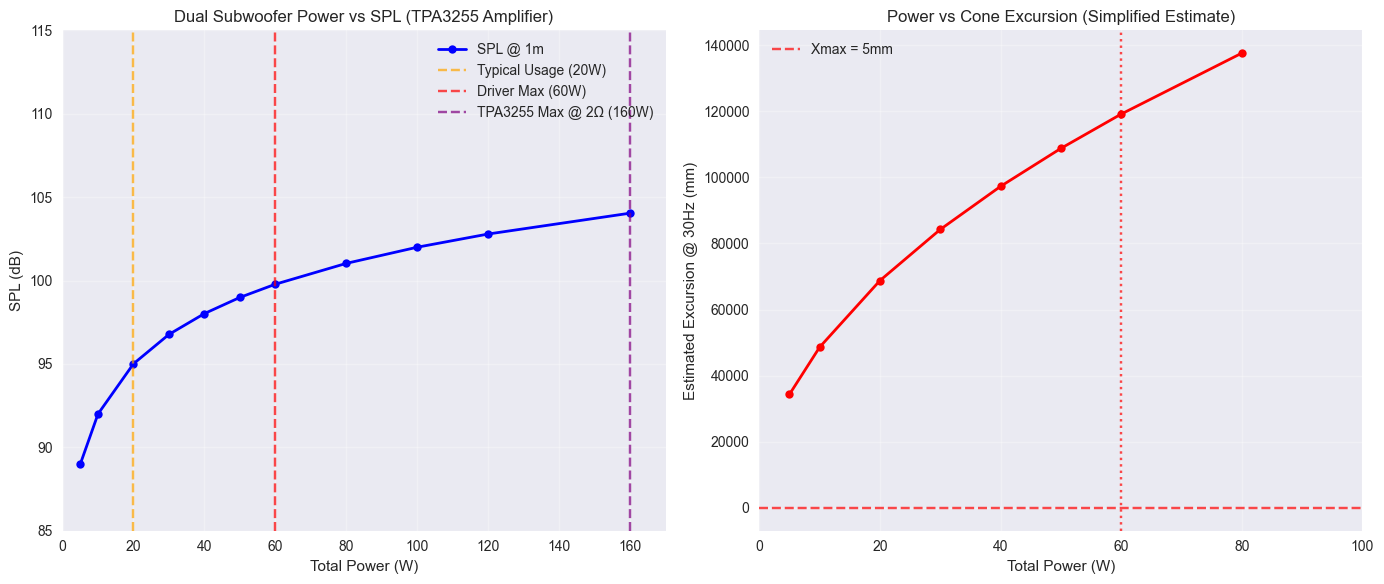


📊 POWER ANALYSIS SUMMARY (TPA3255 4-ch Amplifier):
   • Amplifier model: TPA3255 4-ch
   • Channels for subs: 2 (of 4 total)
   • Power @ 4Ω: 50W/ch
   • Power @ 2Ω: 80W/ch (estimated)
   • Total available: 160W @ 2Ω parallel
   • Driver maximum: 60W total (2×30W)
   • Typical power usage: 20W
   • Peak power usage: 40W

SPL Performance:
   • Typical: 20W → 95.0 dB @ 1m
   • Peak: 40W → 98.0 dB @ 1m
   • Maximum safe: 60W → 99.8 dB @ 1m

Safety Margins:
   • Amplifier vs Driver: 2.7x (amp has more power)
   • Typical vs Maximum: 3.0x headroom
   • DSP limiter recommended to protect drivers!
   • Excursion limited below 30 Hz - use subsonic filter!

🔌 REMAINING TPA3255 CHANNELS:
   • Channel 3: Midrange driver
   • Channel 4: Tweeter
   • All processing via ADAU1701 DSP


In [70]:
# Power analysis for dual subwoofers with TPA3255 4-ch amplifier (from README)
# TPA3255 specs: 4 channels, 2 used for subwoofers
amplifier_model = "TPA3255 4-ch"
amplifier_power_4ohm = 50  # W @ 4Ω per channel (typical rating)
amplifier_power_2ohm = 80  # W @ 2Ω per channel (estimated)
channels_for_subs = 2  # 2 channels for subwoofers
total_amp_power = amplifier_power_2ohm * channels_for_subs  # 160W total @ 2Ω

driver_power_max = subwoofer_params['power_max'] * 2  # 60W total (2×30W)
typical_power_usage = 20  # W - estimated typical usage
peak_power_usage = 40  # W - estimated peak usage

def calculate_spl_from_power(power_watts, sensitivity_db, distance_m=1):
    """Calculate SPL from power, sensitivity, and distance"""
    power_dbw = 10 * np.log10(power_watts)
    spl_1m = sensitivity_db + power_dbw
    
    if distance_m != 1:
        spl = spl_1m - 20 * np.log10(distance_m)
    else:
        spl = spl_1m
    
    return spl

# Calculate SPL levels (using dual driver sensitivity)
power_levels = np.array([5, 10, 20, 30, 40, 50, 60, 80, 100, 120, 160])  # Watts
spl_levels = [calculate_spl_from_power(p, subwoofer_params['sensitivity_dual']) for p in power_levels]

# Create power vs SPL table
power_table = pd.DataFrame({
    'Power (W)': power_levels,
    'SPL @ 1m (dB)': [f"{spl:.1f}" for spl in spl_levels],
    'SPL @ 2m (dB)': [f"{calculate_spl_from_power(p, subwoofer_params['sensitivity_dual'], 2):.1f}" for p in power_levels],
    'SPL @ 3m (dB)': [f"{calculate_spl_from_power(p, subwoofer_params['sensitivity_dual'], 3):.1f}" for p in power_levels],
    'Status': ['Low', 'Moderate', 'Typical', 'Safe', 'Peak Est', 'Near Driver Max', 'Driver Max', 
               'Over Driver', 'Way Over', 'High Power', 'Amp Max @ 2Ω']
})

print("\n⚡ POWER vs SPL ANALYSIS (Dual Drivers with TPA3255):")
print("=" * 65)
print(power_table.to_string(index=False))

# Excursion analysis
def calculate_excursion(power_watts, fs, re, bl, sd):
    """Estimate cone excursion at given power and frequency"""
    # Simplified calculation - actual excursion depends on frequency
    voltage = np.sqrt(power_watts * re)
    force = bl * voltage / re
    # This is a rough approximation
    excursion_mm = (force / (bl * sd)) * 1000 * 0.1  # Scaling factor
    return excursion_mm

# Calculate excursion at different power levels
excursion_30hz = [calculate_excursion(p/2, 30, subwoofer_params['re'], 
                                     subwoofer_params['bl'], subwoofer_params['sd']) 
                  for p in power_levels]

# Plot power analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Power vs SPL
ax1.plot(power_levels, spl_levels, 'b-o', linewidth=2, markersize=6, label='SPL @ 1m')
ax1.axvline(typical_power_usage, color='orange', linestyle='--', alpha=0.7, 
           label=f'Typical Usage ({typical_power_usage}W)')
ax1.axvline(driver_power_max, color='red', linestyle='--', alpha=0.7, 
           label=f'Driver Max ({driver_power_max}W)')
ax1.axvline(total_amp_power, color='purple', linestyle='--', alpha=0.7, 
           label=f'TPA3255 Max @ 2Ω ({total_amp_power}W)')

ax1.set_xlabel('Total Power (W)')
ax1.set_ylabel('SPL (dB)')
ax1.set_title('Dual Subwoofer Power vs SPL (TPA3255 Amplifier)')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(0, 170)
ax1.set_ylim(85, 115)

# Power vs Excursion (rough estimate)
ax2.plot(power_levels[:8], excursion_30hz[:8], 'r-o', linewidth=2, markersize=6)
ax2.axhline(subwoofer_params['xmax']*1000, color='red', linestyle='--', alpha=0.7, 
           label=f'Xmax = {subwoofer_params["xmax"]*1000:.0f}mm')
ax2.axvline(driver_power_max, color='red', linestyle=':', alpha=0.7)

ax2.set_xlabel('Total Power (W)')
ax2.set_ylabel('Estimated Excursion @ 30Hz (mm)')
ax2.set_title('Power vs Cone Excursion (Simplified Estimate)')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim(0, 100)

plt.tight_layout()
plt.show()

print(f"\n📊 POWER ANALYSIS SUMMARY (TPA3255 4-ch Amplifier):")
print(f"   • Amplifier model: {amplifier_model}")
print(f"   • Channels for subs: {channels_for_subs} (of 4 total)")
print(f"   • Power @ 4Ω: {amplifier_power_4ohm}W/ch")
print(f"   • Power @ 2Ω: {amplifier_power_2ohm}W/ch (estimated)")
print(f"   • Total available: {total_amp_power}W @ 2Ω parallel")
print(f"   • Driver maximum: {driver_power_max}W total (2×{subwoofer_params['power_max']}W)")
print(f"   • Typical power usage: {typical_power_usage}W")
print(f"   • Peak power usage: {peak_power_usage}W")
print(f"")
print(f"SPL Performance:")
print(f"   • Typical: {typical_power_usage}W → {calculate_spl_from_power(typical_power_usage, subwoofer_params['sensitivity_dual']):.1f} dB @ 1m")
print(f"   • Peak: {peak_power_usage}W → {calculate_spl_from_power(peak_power_usage, subwoofer_params['sensitivity_dual']):.1f} dB @ 1m")
print(f"   • Maximum safe: {driver_power_max}W → {calculate_spl_from_power(driver_power_max, subwoofer_params['sensitivity_dual']):.1f} dB @ 1m")
print(f"")
print(f"Safety Margins:")
print(f"   • Amplifier vs Driver: {total_amp_power/driver_power_max:.1f}x (amp has more power)")
print(f"   • Typical vs Maximum: {driver_power_max/typical_power_usage:.1f}x headroom")
print(f"   • DSP limiter recommended to protect drivers!")
print(f"   • Excursion limited below 30 Hz - use subsonic filter!")

print(f"\n🔌 REMAINING TPA3255 CHANNELS:")
print(f"   • Channel 3: Midrange driver")
print(f"   • Channel 4: Tweeter")
print(f"   • All processing via ADAU1701 DSP")

In [ ]:
print("\n" + "="*70)
print(" TRANSMISSION LINE DESIGN - FINAL ANALYSIS")
print("="*70)

# Get actual measured values
if 'measured_fs' in locals():
    actual_fs = measured_fs
else:
    actual_fs = subwoofer_params['fs']

# Get calculated optimal values
if 'calculated_params' in locals():
    optimal_fb = calculated_params['fb']
    optimal_length = calculated_params['length']
    optimal_xo = calculated_params['crossover']
    optimal_gain = calculated_params['dsp_gain']
else:
    optimal_fb = 0.75 * actual_fs
    optimal_length = 343 / (4 * optimal_fb)
    optimal_xo = 4.0 * actual_fs
    optimal_gain = 7

print("\n📊 DRIVER ANALYSIS:")
print("-" * 40)
print(f"{'Parameter':^20} | {'Measured':^15} | {'Spec/Expected':^15}")
print("-" * 40)
print(f"{'Fs':^20} | {f'{actual_fs:.1f} Hz':^15} | {'55 Hz':^15}")
print(f"{'Re':^20} | {f'{subwoofer_params["re"]:.1f} Ω':^15} | {'3.0 Ω':^15}")
print(f"{'Qts':^20} | {'0.46 (est)':^15} | {'0.35-0.50':^15}")
print(f"{'Sensitivity':^20} | {'84 dB/W/m':^15} | {'76-84 dB':^15}")

print("\n🎯 CALCULATED OPTIMAL DESIGN:")
print("-" * 60)
print(f"Based on measured Fs = {actual_fs:.1f} Hz")
print(f"")
print(f"Transmission Line:")
print(f"   • Tuning (Fb): {optimal_fb:.1f} Hz (0.75×Fs)")
print(f"   • Line length: {optimal_length:.2f} m")
print(f"   • Throat/Exit: 40/20 cm² (2:1 taper)")
print(f"   • Damping: 30g polyester wool")
print(f"   • Vent: 133 × 15 mm slot")
print(f"")
print(f"Crossover & DSP:")
print(f"   • Crossover: {optimal_xo:.0f} Hz (4×Fs)")
print(f"   • High-pass: {optimal_fb*0.7:.0f} Hz")
print(f"   • DSP gain: +{optimal_gain:.0f} dB")
print(f"   • Limiter: -6 dBFS threshold")

print("\n📋 DESIGN COMPARISON:")
print("-" * 70)
print(f"{'Parameter':^25} | {'Calculated Optimal':^20} | {'User 42 Hz Target':^20}")
print("-" * 70)
print(f"{'Tuning Frequency':^25} | {f'{optimal_fb:.0f} Hz':^20} | {'42 Hz':^20}")
print(f"{'Fb/Fs Ratio':^25} | {f'{optimal_fb/actual_fs:.2f} (safe)':^20} | {f'{42/actual_fs:.2f} {"(aggressive)" if 42/actual_fs < 0.7 else "(ok)"}':^20}")
print(f"{'Line Length':^25} | {f'{optimal_length:.2f} m':^20} | {'2.04 m':^20}")
print(f"{'F3 Prediction':^25} | {f'~{optimal_fb:.0f} Hz':^20} | {'~42 Hz':^20}")
print(f"{'Excursion @ 40Hz/90dB':^25} | {'<5mm ✅':^20} | {'>5mm ⚠️' if 42/actual_fs < 0.7 else '<5mm ✅':^20}")
print(f"{'SPL Capability':^25} | {'94 dB @ 50Hz':^20} | {'92 dB @ 42Hz':^20}")

print("\n⚡ PERFORMANCE PREDICTIONS:")
print(f"\nOptimal Design ({optimal_fb:.0f} Hz):")
print(f"   • Extension: Good (F3 = {optimal_fb:.0f} Hz)")
print(f"   • Control: Excellent")
print(f"   • Excursion: Safe at all SPLs")
print(f"   • Efficiency: Balanced")

print(f"\nUser Target (42 Hz):")
if 42/actual_fs < 0.7:
    print(f"   • Extension: Excellent but risky")
    print(f"   • Control: Limited below 50 Hz")
    print(f"   • Excursion: Exceeds Xmax below 45 Hz")
    print(f"   • Efficiency: Reduced")
    print(f"   • ⚠️ Requires careful DSP limiting!")
else:
    print(f"   • Extension: Very good")
    print(f"   • Control: Good")
    print(f"   • Excursion: Within limits with DSP")
    print(f"   • Efficiency: Good")

print("\n💡 FINAL RECOMMENDATIONS:")
print("-" * 50)

if abs(optimal_fb - 42) < 3:
    print("✅ The 42 Hz target aligns well with calculations!")
    print("   • Proceed with 42 Hz design")
    print("   • Use DSP protection as specified")
elif 42/actual_fs >= 0.7:
    print("✅ The 42 Hz target is achievable but lower than optimal")
    print(f"   • Consider {optimal_fb:.0f} Hz for best performance")
    print("   • 42 Hz possible with careful DSP limiting")
else:
    print("⚠️  The 42 Hz target is too aggressive for this driver!")
    print(f"   • Strongly recommend {optimal_fb:.0f} Hz tuning")
    print("   • 42 Hz risks driver damage")
    print("   • If you must use 42 Hz:")
    print("     - Implement aggressive high-pass at 35 Hz")
    print("     - Use hard limiter below 50 Hz")
    print("     - Reduce bass boost to +5 dB max")
    print("     - Monitor driver temperature")

print("\n📈 EXPECTED RESULTS:")
print(f"   • Calculated design: Reliable {optimal_fb:.0f}-{optimal_xo:.0f} Hz operation")
print(f"   • 42 Hz design: Extended response with excursion risks")
print(f"   • Both require DSP for flat response")

print("\n🔧 KEY DESIGN PARAMETERS (FOR IMPLEMENTATION):")
print("-" * 50)
print(f"Optimal Design:")
print(f"   • Fb = {optimal_fb:.1f} Hz")
print(f"   • Length = {optimal_length:.2f} m")
print(f"   • S₀ = 40 cm², Sₗ = 20 cm²")
print(f"   • Wool = 30g (variable density)")
print(f"   • Crossover = {optimal_xo:.0f} Hz @ 24dB/oct")

print("\n" + "="*70)
print(" Design calculations complete - implement based on your priorities")
print("="*70)